In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

model_name = 'ResNet32_acc893.h5'
model = keras.models.load_model(model_name)
squeeze_bits = 4

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [2]:
from utils import cifar10_load
(x_train, y_train), (x_dev, y_dev), (x_test, y_test) = cifar10_load()

Using TensorFlow backend.


In [3]:
clean_images = np.load('../../pickles/cleanimages.npy')
attack_results = np.load('../../pickles/advimages.npy')

In [4]:
x = tf.placeholder(tf.float32, shape=(None,32,32,3))
#def squeeze(x):
#    return int(x*(2^squeeze_bits-1))/float(squeeze_bits-1)

#wrap = tf.py_func(squeeze, [x], tf.float32)
#x_squeeze = int(x*(2^squeeze_bits-1))/float(squeeze_bits-1)
npp_int = 2**squeeze_bits-1
x_int = tf.rint(tf.multiply(x, npp_int))
x_squeeze = tf.div(x_int, npp_int)

x_out = model(x)
squeeze_out = model(x_squeeze)

score = tf.reduce_sum(tf.abs(x_out-squeeze_out))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [5]:
sess = keras.backend.get_session()
output_probs= []
true_label = []
for adv_images in attack_results:
    adv_prob = np.array([sess.run(score, feed_dict={x: adv_image.reshape(-1, 32, 32, 3)}) for adv_image in adv_images])
    clean_prob = np.array([sess.run(score, feed_dict={x: clean_image.reshape(-1, 32, 32, 3)})  for clean_image in clean_images])
    output_probs.append(np.concatenate([adv_prob, clean_prob]))
    true_label.append(np.concatenate([np.ones_like(adv_prob), np.zeros_like(clean_prob)]))

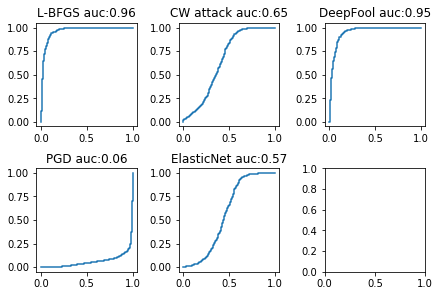

In [6]:
%matplotlib inline

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

attack_names = ['L-BFGS', 'CW attack', 'DeepFool', 'PGD', 'ElasticNet']
assert len(true_label) == len(output_probs), "Error due to in compatibility with label and probs"


fig, axs = plt.subplots(2, 3, constrained_layout=True)
for i in range(len(output_probs)):
    fpr, tpr, thresholds = roc_curve(true_label[i], output_probs[i])
    roc_auc = auc(fpr, tpr)
    axs[i//3, i%3].plot(fpr, tpr)
    axs[i//3, i%3].set_title(attack_names[i]+' auc:%0.2f'%roc_auc)
plt.show()

In [20]:
for i in range(5):
    print(model.predict(attack_results[i][74].reshape(-1,32,32,3)))

[[5.0172967e-01 1.9826766e-04 6.2839098e-09 5.0566001e-08 5.1430927e-08
  1.2588602e-08 1.9114384e-06 1.5619671e-06 3.5594162e-03 4.9450910e-01]]
[[9.9994493e-01 6.2625685e-07 1.5607865e-09 1.6766744e-10 1.1434395e-08
  2.6219582e-10 1.1562032e-08 6.0602446e-08 3.2040691e-05 2.2338654e-05]]
[[5.2115506e-01 2.0046141e-04 7.5336866e-09 6.0401810e-08 5.7376955e-08
  1.2944845e-08 2.3802631e-06 1.4742212e-06 5.5837543e-03 4.7305676e-01]]
[[9.2364602e-17 1.0000000e+00 8.7943623e-14 2.1165691e-14 3.2096032e-26
  5.4049626e-10 7.2404856e-12 5.3613702e-20 1.1582807e-18 5.3588048e-16]]
[[9.9998498e-01 9.0211302e-08 8.0327389e-10 2.6740846e-10 7.7684099e-09
  2.4568850e-10 2.1608054e-08 1.6005730e-08 1.3317284e-05 1.5667184e-06]]


In [21]:
model.predict(clean_images[74].reshape(-1,32,32,3))

array([[4.6068733e-03, 4.7435246e-05, 3.6993278e-10, 7.0976718e-09,
        1.6266445e-09, 9.6065333e-10, 2.3828494e-07, 9.7132954e-08,
        2.6060091e-04, 9.9508470e-01]], dtype=float32)

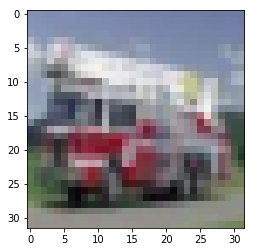

In [22]:
plt.imshow(attack_results[0][74])

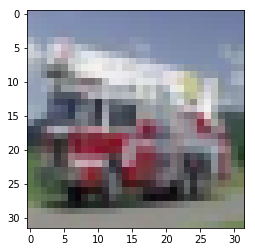

In [16]:
plt.imshow(clean_images[74])